In [1]:
#IMPORTS 
import sys
import numpy as np
import matplotlib.pyplot as plt
sys.path.append(r"C:\Users\DGaard\Desktop\Gits\MoleculeSim\ownSim")
#sys.path.append(r"C:\Users\EmilR\Documents\GitHub\MoleculeSim\ownSim")

import forces as fc
import molecules as mc
import random
import copy
from tqdm import tqdm
import util
import img3dto2d as i32

In [2]:
#force
threshold = 1
def custom_force1(m1,m2):
  f = fc.total_force_molecule(m1,m2, threshold = threshold ) #fc. ,threshold=threshold
  return f * 3



def lin_attraction(x, b =-20):
  if x >= threshold:
    return min((1/10)*x + b,0)
  else:
    return fc.MAX_FORCE_VAL # fc.


def custom_force2(m1,m2):
  h = mc.inter_dist(m1,m2)
  return lin_attraction(h) 

In [3]:
#setup universe

# Parameters for universe initialization
box_const_size = 3800
box_size = np.array([box_const_size,box_const_size,box_const_size]) #max coordinate values for universe
#num_molecules = 5
num_steps = 1_00_000
num_molecules = 1000
radius = 100
radii  = util.get_n_radii(num_molecules) #change another variable when creating new radius
#other setup
seed = 1414 #1313

#combs = grid_points(box_size, radius, spacing)
#molecules = [mc.Molecule(pos, radius) for pos in combs]

force_func = custom_force1
#uni = mc.SimpleUniverse(box_size, len(molecules),np.repeat(radius,len(molecules)),seed, own_molecules = molecules, force_fun = cust_force)
uni = mc.SimpleUniverse(box_size, num_molecules,radii,seed, force_fun = force_func)
print(type(uni.molecules[0].pos[0]))

<class 'numpy.float64'>


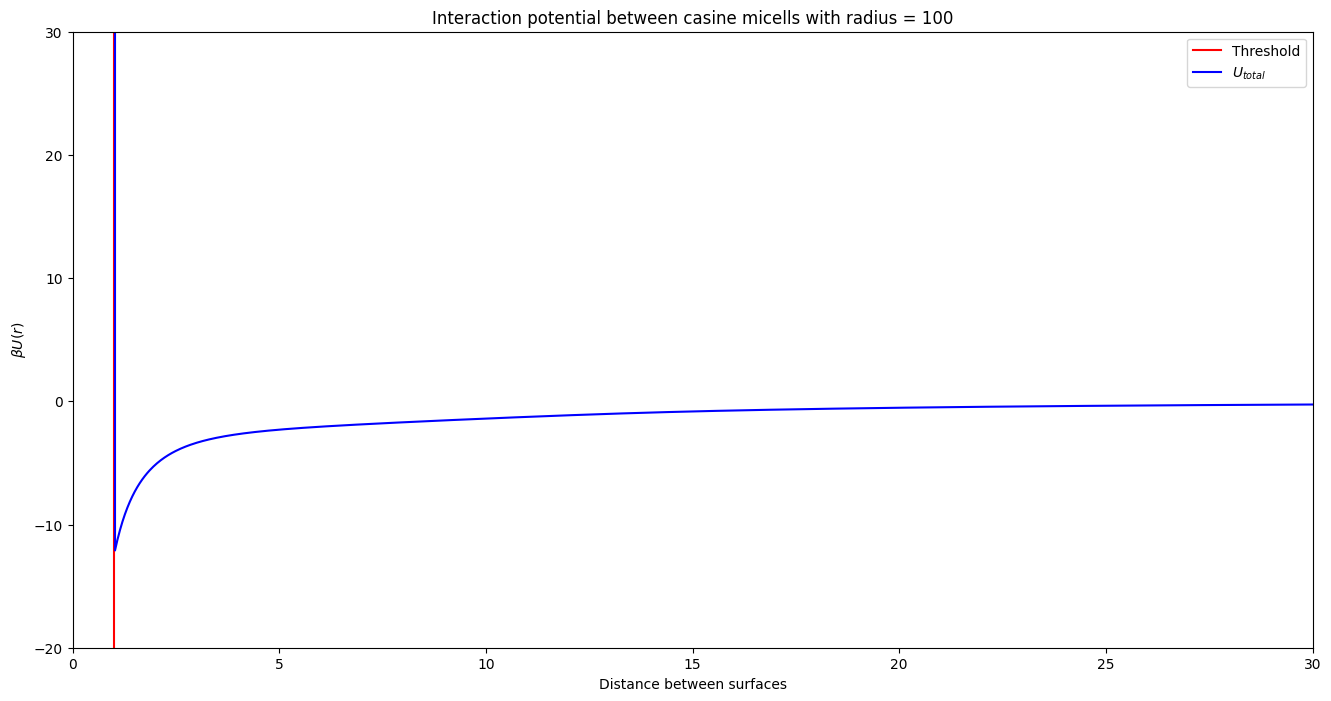

In [4]:
#plot force between two molecules:

#spawn two molecules at different distances
interdists = np.linspace(0.1,30,1000)
forces = []
for i in interdists:
  dist_between = 2*radius + i
  m1 = mc.Molecule(np.array([0.0,0.0,0.0]),radius)
  m2 = mc.Molecule(np.array([dist_between,0.0,0.0]),radius)
  f = force_func(m1,m2)
  forces.append(f)

plt.figure(figsize=(16,8))

plt.axvline(x=threshold,label = "Threshold",c="red")
plt.plot(interdists, forces, c="blue", label = "$U_{total}$")

plt.ylim((-20,30))
plt.xlim((0,30))
plt.title(f"Interaction potential between casine micells with radius = {radius}")
plt.xlabel("Distance between surfaces")
plt.ylabel(r"$\beta U(r)$")
plt.legend()
plt.show()



In [5]:
#see density
box_vol = box_const_size**3
sphere_vol = 0
for r in radii:
  sphere_vol += ((4/3)*r**3*np.pi)


print("Upper bound amount of spheres: ", box_vol/((4/3)*radius**3 * np.pi))
print("Density: ", sphere_vol/box_vol)

Upper bound amount of spheres:  13099.725056007723
Density:  0.12998333310029495


In [6]:
#run univers # steps
points = []
_, radii = uni.get_state(with_radius= True)

# Perform Simulation
for i in tqdm(range(num_steps)):
  #randomly select a molecule
  uni.make_step()
  #store intermediate results?
  points.append(uni.get_state())

acc, rej, accs, num = uni.get_stats()
print(f"Accepted: {acc}, Rejected: {rej}, Rate: {acc/num}")

  2%|▏         | 1586/100000 [00:21<22:38, 72.43it/s]


KeyboardInterrupt: 

In [ ]:
#extract points

#show every 100 points
frame_step_size = 1000

xs = np.array([inner_list[0] for sublist in points for inner_list in sublist]).reshape((num_steps,num_molecules))
ys = np.array([inner_list[1] for sublist in points for inner_list in sublist]).reshape((num_steps,num_molecules))
zs = np.array([inner_list[2] for sublist in points for inner_list in sublist]).reshape((num_steps,num_molecules))

xs = [xs[i] for i in range(len(xs)) if i % frame_step_size == 0]
ys = [ys[i] for i in range(len(ys)) if i % frame_step_size == 0]
zs = [zs[i] for i in range(len(zs)) if i % frame_step_size == 0]

frame_nums = [i for i in range(0,num_steps,frame_step_size)]
point_frames = [points[frame] for frame in frame_nums]

In [ ]:
name = ""
save_space = True


if save_space:
  name = mc.save_molecule_steps(point_frames,radii,accs, box_const_size)
else:
  name = mc.save_molecule_steps(points,radii, accs,box_const_size)

In [ ]:
#calculate statistics


#assumes constant radius
def check_for_overlap(frames,radii):
    overlaps = []
    for frame in tqdm(frames):
        cum = 0
        for i in range(len(frame)):
            mol1 = frame[i]
            rad1 = radii[i]
            for j in range(i+1,len(frame)):
                mol2 = frame[j]
                rad2 = radii[j]
                current_dist = np.linalg.norm(mol2-mol1) - rad1 - rad2
                if current_dist < 0:
                    cum += 1
        avg = cum
        overlaps.append(avg)

    return overlaps

#assumens constant radius
def avg_dist(frames,radii):
    dist = []
    for frame in tqdm(frames):
        cum = 0
        #ctr = 0
        for i in range(len(frame)):
            mol1 = frame[i]
            rad1 = radii[i]
            for j in range(i+1,len(frame)):
                mol2 = frame[j]
                rad2 = radii[j]
                current_dist = np.linalg.norm(mol2-mol1) - rad1 - rad2
                cum += current_dist
                #ctr += 1
        #print(ctr,((len(frame)) * (len(frame)-1))/2)
        avg = cum / (((len(frame)) * (len(frame)-1))/2) #(N*(N-1)/2)
        dist.append(avg)
    return dist

#assumens constant radius
def avg_k_dist(frames,radii,k):
    dist = []
    for frame in tqdm(frames):
        cum = 0
        for i in range(len(frame)):
            mol1 = frame[i]
            rad1 = radii[i]
            cum_list = []
            for j in range(len(frame)):
                if (j != i):
                    mol2 = frame[j]
                    rad2 = radii[j]
                    current_dist = np.linalg.norm(mol2-mol1) - rad1 - rad2
                    cum_list.append(current_dist)
            cum_list = sorted(cum_list)
            cum += sum(cum_list[:k])
        avg = cum / (k*len(frame))
        dist.append(avg)
    return dist

#acceptence/rejectance rate
def mc_rate(acc_list):
    res_accs = []
    res_rejs = []

    acc_cum = 0
    rej_cum = 0
    lenght = len(acc_list)

    for i in acc_list:
        if i:
            acc_cum += 1
        else:
            rej_cum += 1


        res_accs.append(acc_cum / lenght)
        res_rejs.append(rej_cum / lenght)

    return res_accs, res_rejs


In [ ]:
avg_dists = avg_dist(point_frames,radii)

#plot avg distance
plt.plot(frame_nums,avg_dists)
plt.title(f"Average distance for different frames with {num_molecules} molecules")
plt.xlabel("Frame number")
plt.ylabel("Avg distance [nm]")
plt.show()

In [ ]:
overlaps = check_for_overlap(point_frames, radii)

#plot avg distance
plt.plot(frame_nums,overlaps)
plt.title(f"Overlaps with {num_molecules} molecules")
plt.xlabel("Frame number")
plt.ylabel("Amount")
plt.show()

100%|██████████| 100/100 [03:12<00:00,  1.93s/it]


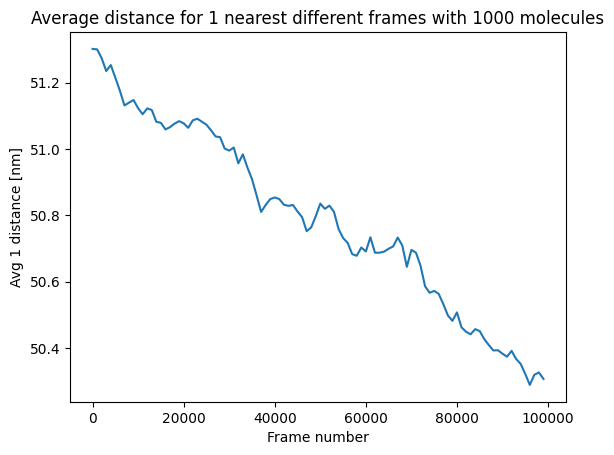

In [ ]:
k = 1
k_dists = avg_k_dist(point_frames,radii,k)

#plot avg distance
plt.plot(frame_nums,k_dists)
plt.title(f"Average distance for {k} nearest different frames with {num_molecules} molecules")
plt.xlabel("Frame number")
plt.ylabel(f"Avg {k} distance [nm]")
plt.show()

In [ ]:
acceptances, rejections = mc_rate(accs)

#plot acceptance and rejectance 
plt.plot(acceptances,label="acc")
plt.plot(rejections,label="rej")
plt.title(f"Amount of rejections/acceptances with {num_molecules} molecules")
plt.xlabel("Frame number")
plt.ylabel("Amount")
plt.legend()
plt.show()

In [ ]:
#advanced interupt
0/0

ZeroDivisionError: division by zero

In [ ]:
#mayavi visualize
from __future__ import absolute_import, division, print_function
from mayavi import mlab
import numpy as np
import math
num_molecules = len(uni.molecules)


mlab.clf()
#mlab.points3d(0,0,0)

# plt = mlab.points3d([0], [0], [0], resolution = 100, scale_factor = 100*2)
# plt = mlab.points3d([300], [0], [0], resolution = 100, scale_factor = 200*2)
#plt = mlab.points3d(points[0][:, 0], points[0][:, 1], points[0][:, 2], resolution = 10, scale_factor = radius*2)
plt = [mlab.points3d(points[0][i, 0], points[0][i, 1], points[0][i, 2], resolution = 10, scale_factor = radii[i]) for i in range(num_molecules)]
mlab.axes(extent = [0,box_size[0],0,box_size[1],0,box_size[2]])#ranges = [-100,500,-200,200,-200,200]
text_position = (0,0,0)
text_actor = mlab.text3d(500,150, 510, "TESTING", scale = 40, color = (0,0,0))
@mlab.animate(delay = 100, ui = True, support_movie = True) #delay = 100
def anim():
    f = mlab.gcf()
    while True:
        #temp = "step: "
        for step in range(len(xs)):#num_steps
            x = xs[step]#points[step][:, 0]
            y = ys[step]#points[step][:, 1]
            z = zs[step]#points[step][:, 2]
            for i in range(num_molecules):
                plt[i].mlab_source.set(x=x[i], y=y[i], z=z[i])
            text_actor.text = f"Frame: {step}"
            
            yield


anim()
mlab.show()

********************************************************************************
         to build the TVTK classes (9.2). This may cause problems.
         Please rebuild TVTK.
********************************************************************************



In [ ]:
#advance interupt
0/0

ZeroDivisionError: division by zero

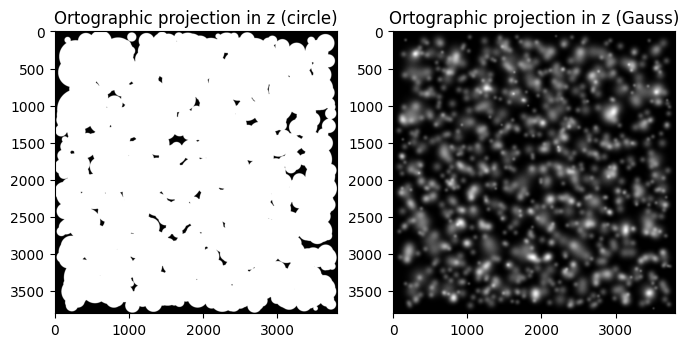

In [ ]:
#plot universe
i32.plot_universe_in_2d(uni)

In [ ]:
#advanced interupt
0/0

In [ ]:
# import numpy as np
# import uuid

In [ ]:
# a = np.array([1,2,3])
# b = np.array([4,5,6])
# c = np.array([a,b])
# with open('test.npy', 'wb') as f:
#   np.save(f,a)
#   np.save(f,b)

# with open('test.npy', 'rb') as f:
#   a2 = np.load(f)
#   b2 = np.load(f)

# d = np.load("test.npy")
# print(a2)
# print(b2)

[1 2 3]
[4 5 6]


In [ ]:
# def save_molecule_steps(points,radii,name="simV3R"):
#   #create unique name
#   name = name + "_" + str(len(points)) + "_" + str(uuid.uuid4().hex)[:5] + ".npy"

#   with open(name, 'wb') as f:
#     np.save(f,np.array(points))
#     np.save(f,np.array(radii))

#   return name


# def load_molecule_steps(name):
#   with open(name, 'rb') as f:
#     poss = np.load(f)
#     radii = np.load(f)
#   return poss, radii

# a = np.array([1,2,3])
# b = np.array([4,5,6])

# name = mc.save_molecule_steps(a,b)



#save points array
#np.save("point_example2.npy",np.array(points))
#np.load("point_example.npy").shape

In [ ]:
# c = mc.load_molecule_steps(name)

# print(c[0],c[1])

[1 2 3] [4 5 6]
